Using your laptop/desktop webcam, create a video that contains the background
for the first few seconds followed by your entry in the video.
Using this generated video, generate foreground (in the form of a B/W image) by
implementing:
a) Intrusion detection using a single background frame as a reference.
b) Intrusion detection using unimodal background modelling.
c) Now implement the Background model update to the above part.

# Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import os
import sys#crash a program
import cv2

# Function to initialise the mean and variance images

In [2]:
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)#9/16 works better by rule of thumb;gives better values
    return(mean,variance)

# Classify images into foreground and background pixels using a Chebyshev inequality based classifier

In [3]:
def ForegroundDetection(img_file,mean,variance,lmda):
    img = cv2.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)#find all vals > 0 its true ;
    rI = 255*mask.astype(int)#if true=1 then 255*1 else 255*0;hence background n foreground image;reduced image(rI)
    rI = rI.astype(np.uint8)#(conversion to binary 8 bit)depending on the illumination,image gets noisy hence intruder doesnt get detected easily.
    return(rI)

# Reduce the image noise using a voting scheme

In [4]:
def Voting(rI,eta,m,n):#taking voting of neighbours depending on its probability n decide central pixel val(noisy pixels(patches of white) wont have more white around)
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):#rectangle of patch inside a image(hence center pixel is inside the rectangle)leave m values to left and n values to top
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:#main step for true or false vals
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n:#depending on eta(80%)white or black center will be decided,hence the voting(if white is more then center is white)
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

# Update the mean and variance images using a weighted average scheme

In [5]:
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:# background image cond(rest is same as slides)
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])#clipping as high var gives noise
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)#var cant go below 9 and noise is eradicated(gives max n min limit)
    return(mean_upd,var_upd)

In [6]:
def Background_Subtraction(img_dir,lmda,eta,m,n,alpha):
    
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    print(variance)
    for i in range(1,19):#starts from 1 as 0th file is already read
        img_path = os.path.join(img_dir,img_file_name[i])#read the image
        
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)#get foreground image
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)#do voting and update mean and var(finalmodel parameter)
        ax[1].imshow(cI,cmap="gray")
        
        img = cv2.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()
    return(mean,variance)

[[[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]

 [[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]

 [[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]

 ...

 [[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]

 [[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]

 [[9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]
  ...
  [9. 9. 9.]
  [9. 9. 9.]
  [9. 9. 9.]]]


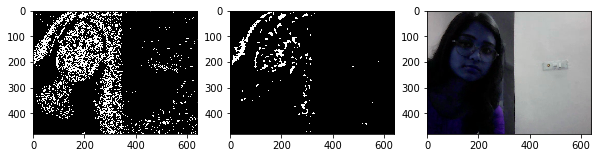

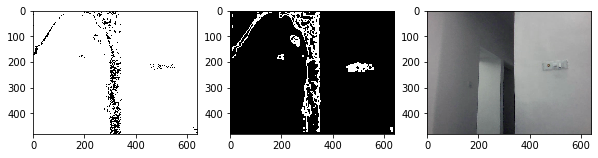

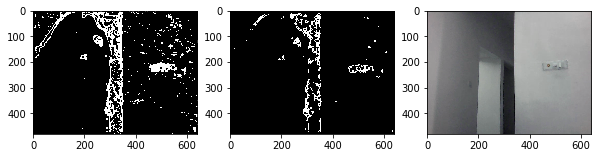

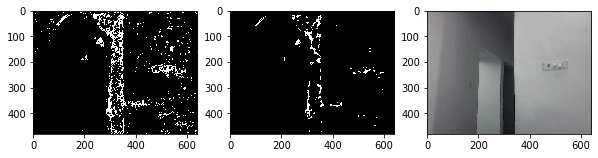

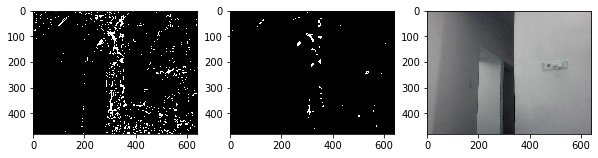

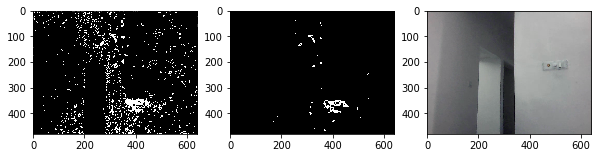

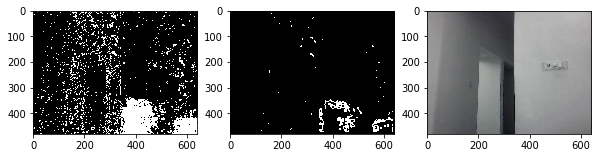

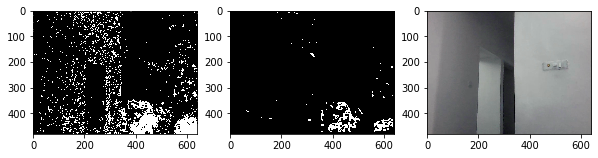

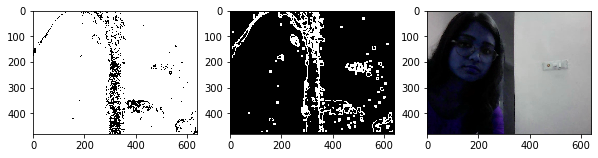

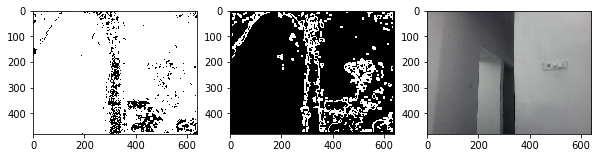

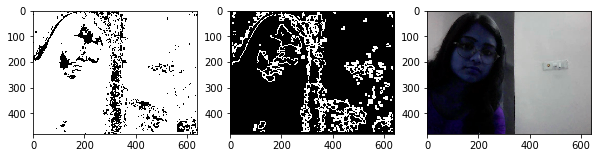

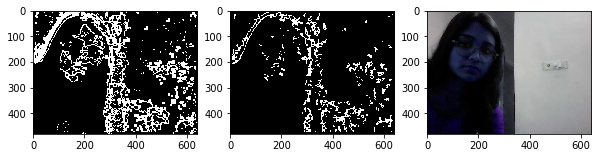

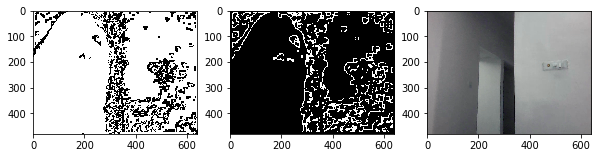

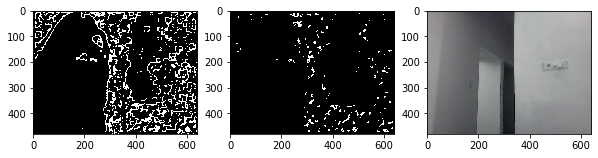

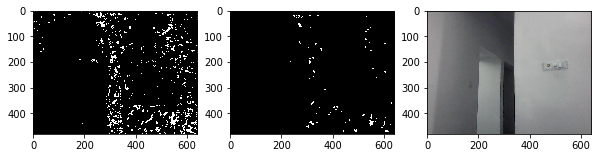

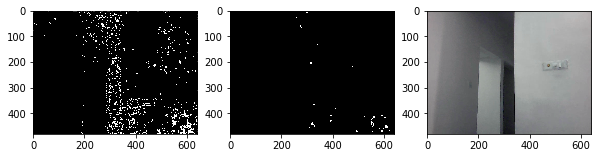

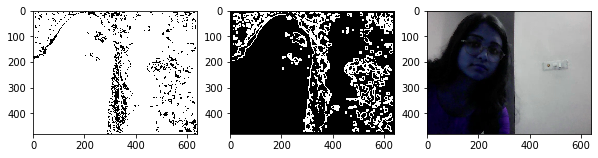

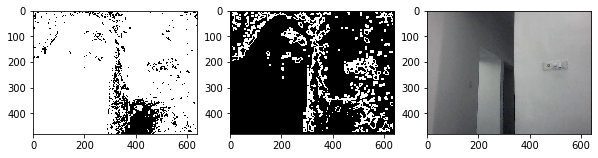

In [10]:
mean,variance = Background_Subtraction("/home/rupeek/Desktop/ML &AI/assns/data",0.8,0.7,8,8,0.8)#in output from left rI(noisy image),cI,actual image

In [ ]:
#unimodal as it has single chebyshev background subtraction;multimodal has GMM on every data hence multi modes it has and will be better output